In [16]:
from matplotlib import pyplot as plt
from tensorflow import keras
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import dlib
from imutils import face_utils
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import os
import cv2
import dlib
import shutil
from tensorflow.keras.preprocessing import image


## input pipeline to preprocess the photo for the model:
## 1. Put photos you want to use in a folder/folders
## 2. Prepare thrash folders for every folder to store
## photos inproper for the network (no face detection)
## 3. Use method all_img_loop on folders with your inputs
## 4. You can load the photos to the netowrk calling 





## Load model
model = tf.keras.models.load_model("/home/data/data/kodeiri/ML_project/saved_model/my_model4")
senior_path = "/home/data/data/kodeiri/ML_project/HM/Senior.txt"
young_path = "/home/data/data/kodeiri/ML_project/HM/Young.txt"
adult_path = "/home/data/data/kodeiri/ML_project/HM/Adult.txt"
## Load heatmap template for each class
HM_shape = (100,100,3) ## template heatmap shape DO NOT CHANGE, only if the original shape changed before saving
## Load detector libraries
detector = dlib.cnn_face_detection_model_v1('/home/data/data/kodeiri/ML_project/dogHeadDetector.dat')
predictor = dlib.shape_predictor('/home/data/data/kodeiri/ML_project/landmarkDetector.dat')
CATEGORIES = ["Adult", "Senior", "Young"]

def predDecoder(prediction):
    x = np.argmax(prediction)
    print("Prediction: " + CATEGORIES[x])
    prob = prediction[x]
    print("Confidence: "+ str(prob))
    return (CATEGORIES[x])

def Image_preprocessor(input_path,res=(100,100)):
    img = image.load_img(input_path, target_size=res)
    img = np.expand_dims(img, axis=0)
    img = img.astype(np.float32)
    img/=255
    return img





def predict_on_examples(dirpath,ground_truth,display_image=False, display_heatmap = False, res = (100,100), intensity = 0.8):
    #iteration_number=len(os.listdir(dirpath))
    iteration_number=5
    i=0
    piclist=os.listdir(dirpath)
    hm_sum = np.zeros((100, 100, 3, 1))
    for i in range(iteration_number):
        img_path=dirpath+piclist[i]
        if display_image == True:
            img = cv2.imread(img_path)
            plt.imshow(img)
            plt.show()
        img = Image_preprocessor(img_path)
        preds = model.predict(img)[0]
        predDecoder(preds)
        print("Ground_truth: "+ ground_truth)
        if display_heatmap == True:
            conv_layer = model.get_layer(index=0)
            heatmap_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])
            with tf.GradientTape() as gtape:
                conv_output, predictions = heatmap_model(img)
                argmax=tf.argmax(predictions[0])
                loss = predictions[:, argmax]
                grads = gtape.gradient(loss, conv_output)
                pooled_grads = K.mean(grads, axis=(0,1,2))

            heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
            heatmap = np.maximum(heatmap, 0)
            max_heat = np.max(heatmap)
            if max_heat == 0:
                max_heat = 1e-10
            heatmap /= max_heat

            img = cv2.imread(img_path)
            heatmap = heatmap.squeeze()
            
            heatmap = cv2.resize(heatmap, res)
            heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_HOT)
            img_hm = heatmap * intensity + img    
            img_hm = cv2.cvtColor(img_hm.astype('float32'), cv2.COLOR_BGR2RGB)
            img_hm = img_hm/np.amax(img_hm)

            fig, ax = plt.subplots(1,3)
            ax[0].imshow(img)
            ax[0].set_title("Input image")
            ax[1].imshow(img_hm)
            ax[1].set_title("Image with heatmap")
            ax[2].matshow(heatmap)
            ax[2].set_title("Heatmap")
            plt.show()

            features = features_detector(img)
            if len(features):
                img = img_rotate(img, features, res=res)
                heatmap = img_rotate(heatmap, features, res=res)

            features = features_detector(img)
            if len(features):
                img = translate_image(img, (50, 50), features,  res=res)
                heatmap = translate_image(heatmap, (50, 50), features,  res=res)
                hm_sum = np.append(hm_sum, heatmap.reshape((100, 100, 3, 1)), axis=3)
    
                if i == iteration_number-1:
                    hm_sum_disp = hm_sum.sum(axis=3)
                    hm_mean = hm_sum.mean(axis=3)
                    hm_median = np.median((hm_sum - hm_sum.mean()) / hm_sum.std() , axis=3)
                    fig, ax = plt.subplots(1, 3, figsize=(20, 30))
                    ax[0].matshow(hm_sum_disp)
                    ax[0].title.set_text('heatmaps sum')
                    ax[1].matshow(hm_mean)
                    ax[1].title.set_text('heatmaps mean')
                    ax[2].matshow(hm_median)
                    ax[2].title.set_text('heatmaps median')
                    plt.show()
                    return hm_sum, hm_sum_disp, hm_mean, hm_median

## heatmap loader
## loads the heatmap from numpy array saved as txt file
## and reshapes it to original shape
## takes path to saved .txt as input
## returns reshaped template image

def Hm_loader(path):
    template_pre =np.loadtxt(path)
    template = template_pre.reshape(template_pre.shape[0], template_pre.shape[1] // 3, 3)
    return template



Senior_template = Hm_loader(senior_path)
Adult_template = Hm_loader(adult_path)
Young_template = Hm_loader(young_path)

## method that detects an image on white background
## takes an image as input
## returns image without background and rescaled to res

def photo_detector(src_image, res =(100,100)):

    img_in = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(img_in, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape

    ret, thresh = cv2.threshold(gray, 254, 255, 1)

    photo_width = np.count_nonzero(thresh == 255, axis=0).max()
    photo_height = np.count_nonzero(thresh == 0, axis=1).min()

    column, row, photo_width, photo_height = cv2.boundingRect(thresh)

    result_image = src_image[row:row + photo_height, column: column + photo_width]

    return cv2.resize(result_image, res)

## method locating facial features on the dog's face
## takes an image as an input
## can be configured to equalize histogram before 
## feature extraction
## returns coordinates of the features if detected

def features_detector(src_image,equalize = True):
    if equalize == True:
        ycrvb_img = cv2.cvtColor(src_image, cv2.COLOR_BGR2YCrCb)
        ycrvb_img[:, :, 0] = cv2.equalizeHist(ycrvb_img[:, :, 0])

        yuv_img = cv2.cvtColor(src_image, cv2.COLOR_BGR2YUV)
        yuv_img[:, :, 0] = cv2.equalizeHist(yuv_img[:, :, 0])

        equlized_img1 = cv2.cvtColor(ycrvb_img, cv2.COLOR_YCrCb2BGR)
        dets = detector(equlized_img1, upsample_num_times=1)
    else:
        dets = detector(src_image, upsample_num_times=1)
    if len(dets):
        shape = predictor(equlized_img1, dets.pop().rect)
        (forehead, right_ear, right_eye, nose, left_ear, left_eye) = face_utils.shape_to_np(shape)

        return (forehead, right_ear, right_eye, nose, left_ear, left_eye)
    else:
        return []


## method that rotates the dog's face to make eyeline horizontal
## takes image nad list of face feature coordinates as input
## returns rotated image

def img_rotate(src_image, face_features, res=(100, 100)):

    (forehead, right_ear, (x2, y2), nose, left_ear, (x1, y1)) = face_features
    
    slope = (y2 - y1) / (x2 - x1)
    rad = np.arctan2(y2 - y1, x2 - x1)
    angle = np.rad2deg(rad)

    cX = int(nose[0])
    cY = int(nose[1])
    rotationMatrix = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotatedImage = cv2.warpAffine(src_image, rotationMatrix, res)

    return rotatedImage

## method 

def translate_image(src_image, translate_destination, feautres, feature_id=3, res=(100, 100)):
    tX, tY = translate_destination
    bX, bY = feautres[feature_id]

    M = np.float32([[1, 0, tX - bX],[0, 1,  tY - bY]])

    return_image = cv2.warpAffine(src_image, M, res)
    return return_image


## method checking if the dog's face was properly rotated and centered
## takes list of face feature coordinates and max. allowed angle as
## an input
## returns True if all angles are below max. allowed value

def check_triangle_angles(face_features, max_angle = 70.0):
    (forehead, right_ear, (x1, y1), (x2, y2), left_ear, (x3, y3)) = face_features

    # calculate distance between dog eyes 
    a = np.sqrt((x1 - x3) ** 2 + (y1 - y3) ** 2)
    # calculate distance between dog left eye and nose 
    b = np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)
    # calculate distance between dog right eye and nose 
    c = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    
    cos_a = (b ** 2 + c ** 2 - a ** 2) / (2 * b * c)
    cos_b = (c ** 2 + a ** 2 - b ** 2) / (2 * a * c)
    cos_c = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)

    angle_a = np.rad2deg(np.arccos(cos_a))
    angle_b = np.rad2deg(np.arccos(cos_b))
    angle_c = np.rad2deg(np.arccos(cos_c))

    # print(angle_a, angle_b, angle_c)
    if angle_a < max_angle and angle_b < max_angle and angle_c < max_angle:
        return True

    return False

## method detecting dogs face
## takes image as an input
## returns coordinates of the face bounding rectangle
## and original image
## if no detection occured returns original image only

def Face_detector(img):
    img_in = img

    img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(img_in, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV) 

    cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    x,y,w,h = cv2.boundingRect(cnt)
    dst = img_in[y:y+h, x:x+w]

    plt.imshow(dst)

    dets = detector(img_in, upsample_num_times=1)

    img_result = img_in.copy()

    for i, d in enumerate(dets):
        x1, y1 = d.rect.left(), d.rect.top()
 
        x2, y2 = d.rect.right(), d.rect.bottom()
        if y1 < 0:
            y1 = 0
        if x1 < 0:
            x1 = 0
        if x2 < 0:
            x2 = 0
        if y2 < 0:
            y2 = 0 
        
    shapes = []

    

    for i, d in enumerate(dets):
        shape = predictor(img_in, d.rect)
        shape = face_utils.shape_to_np(shape)
        shapes.append(shape)
    try:
        return img_result, x1, x2, y1, y2
    except:
        return img_result


## method to crop images with face detector 
## before inputting to network
## takes source folder and thrash folder paths
## as an input
## incorrect photos will be copied to thrash 
## and removed from the source
## correct will be cropped and saved in the same
## folder
## run only ONCE on given folder

def img_preprocess(src,thrash):
  for filename in os.listdir(src):
    string_e=src+filename
    img = cv2.imread(string_e)
    IMG_SIZE =100
    try:
      x, x1, x2, y1, y2 = Face_detector(img)
      x = img[y1:y2,x1:x2]
      x = cv2.resize(x,(IMG_SIZE,IMG_SIZE))
      resized_image = x
      # save same img
      cv2.imwrite(string_e, resized_image)
    except: ## if file not detected, copy to trash folder and remove from the source
      wrong_address = thrash
      shutil.copy(string_e,wrong_address) ## move incorrect files to other folder
      os.remove(string_e)
      continue

## method returning max pixel value occuring
## in a pair of images passed as 4D tf.tensors
## takes pair of images as an input
## can be configured to one picture mode
## returns max pixel value in given images


def max_val_ssim (img1, img2=None, single_arg = False):

    if single_arg==True:
        max1 = tf.math.reduce_max(img1,axis=(0, 1))
        max1 = tf.math.reduce_max(max1,axis=(0, 1))
        max_val = max1.numpy()
        return max_val    
    max1 = tf.math.reduce_max(img1,axis=(0, 1))
    max1 = tf.math.reduce_max(max1,axis=(0, 1))
    max2 = tf.math.reduce_max(img2,axis=(0, 1))
    max2 = tf.math.reduce_max(max2,axis=(0, 1))
    max_val = tf.math.maximum(max1,max2).numpy()
    return max_val




Prediction: Adult
Confidence: 0.9577064
Ground_truth: Adult


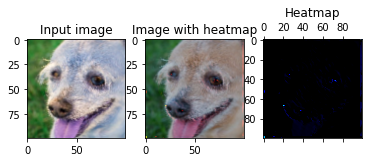

Prediction: Adult
Confidence: 0.9878412
Ground_truth: Adult


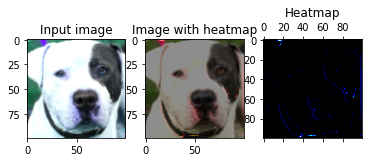

Prediction: Adult
Confidence: 0.99988115
Ground_truth: Adult


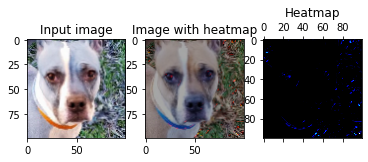

Prediction: Adult
Confidence: 0.97358173
Ground_truth: Adult


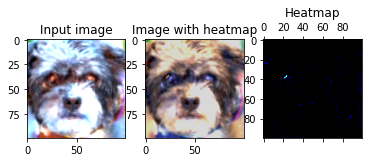

Prediction: Adult
Confidence: 0.9976954
Ground_truth: Adult


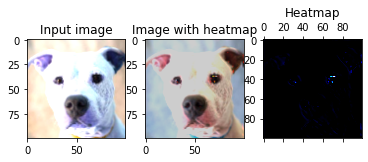

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


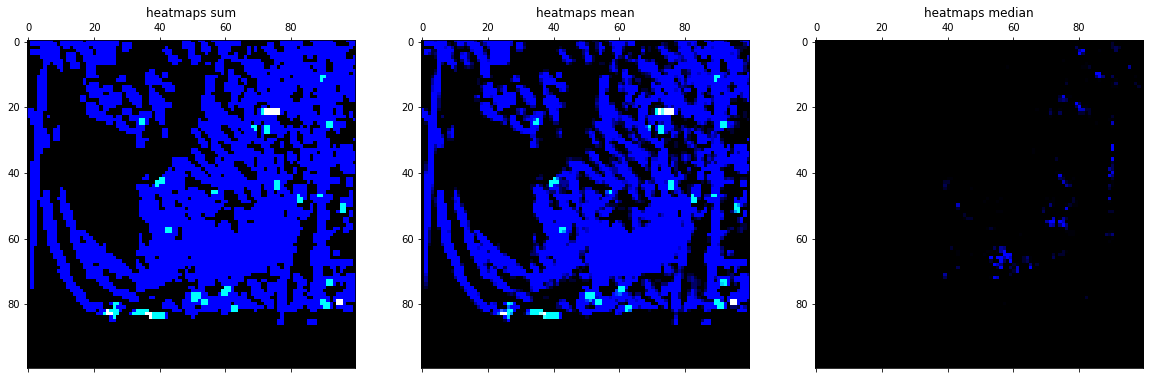

(array([[[[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0., 28.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0., 44.,  0.]],
 
         ...,
 
         [[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  3.]],
 
         [[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  9.]],
 
         [[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0., 12.]]],
 
 
        [[[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0., 17.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  

In [17]:
predict_on_examples("/home/data/data/kodeiri/ML_project/FaceDetector_cropped/Mix_no_yolo_aug/Adult/","Adult",display_heatmap=True)